In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from summit.strategies.tsemo import TSEMO, TSEMOInternalWrapper
from summit.benchmarks import DTLZ2
from summit.utils.models import GPyModel
from summit.utils.multiobjective import pareto_efficient, hypervolume
from summit.utils.dataset import DataSet

from pymoo.model.problem import Problem
from pymoo.algorithms.nsga2 import NSGA2
from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.optimize import minimize
from pymoo.factory import get_termination

from GPy.kern import Exponential
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import warnings
from fastprogress.fastprogress import master_bar, progress_bar
from IPython.display import clear_output

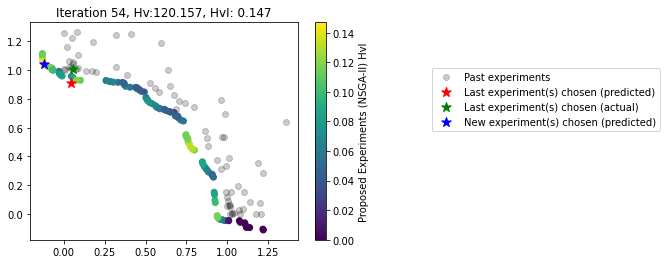

Iteration 55
Fitting models (number of optimization restarts=100)

Model y_0 lengthscales: [1.57649241 6.74851507 5.84056309]
Model y_0 variance: 0.46090105146856963
Model y_0 noise: 0.0024787521766663585
RMSE train y_0 = 0.0
Spectral sampling y_0 with 1500 spectral points.
RMSE train spectral y_0 = 0.02


KeyboardInterrupt caught, calling on_optimization_end() to round things up


Process ForkPoolWorker-448:


KeyboardInterrupt caught, calling on_optimization_end() to round things up


Process ForkPoolWorker-446:


KeyboardInterrupt caught, calling on_optimization_end() to round things up


Process ForkPoolWorker-445:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/Kobi/miniconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/Kobi/miniconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/Kobi/miniconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/Kobi/miniconda3/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
Traceback (most recent call last):
  File "/Users/Kobi/miniconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/Kobi/miniconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/Kobi/miniconda3/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  Fil

Ctrl+c received, terminating and joining pool.


  File "/Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-TfmmV07p-py3.7/lib/python3.7/site-packages/paramz/model.py", line 47, in opt_wrapper
    return m.optimize(**kwargs)
  File "/Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-TfmmV07p-py3.7/lib/python3.7/site-packages/GPy/core/gp.py", line 659, in optimize
    ret = super(GP, self).optimize(optimizer, start, messages, max_iters, ipython_notebook, clear_after_finish, **kwargs)
  File "/Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-TfmmV07p-py3.7/lib/python3.7/site-packages/GPy/core/gp.py", line 659, in optimize
    ret = super(GP, self).optimize(optimizer, start, messages, max_iters, ipython_notebook, clear_after_finish, **kwargs)
  File "/Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-TfmmV07p-py3.7/lib/python3.7/site-packages/GPy/core/gp.py", line 659, in optimize
    ret = super(GP, self).optimize(optimizer, start, messages, max_iters, ipython_notebook, clear_after_finish, **kwargs)
  File "/Users/Kobi

KeyboardInterrupt caught, calling on_optimization_end() to round things up

  File "/Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-TfmmV07p-py3.7/lib/python3.7/site-packages/GPy/util/linalg.py", line 210, in pdinv
    Ai, _ = dpotri(L, lower=1)


Process ForkPoolWorker-447:
  File "/Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-TfmmV07p-py3.7/lib/python3.7/site-packages/GPy/util/linalg.py", line 142, in dpotri
    R, info = lapack.dpotri(A, lower=lower) #needs to be zero here, seems to be a scipy bug
  File "/Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-TfmmV07p-py3.7/lib/python3.7/site-packages/scipy/optimize/_differentiable_functions.py", line 73, in update_fun
    self.f = fun_wrapped(self.x)
  File "/Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-TfmmV07p-py3.7/lib/python3.7/site-packages/scipy/optimize/_differentiable_functions.py", line 70, in fun_wrapped
    return fun(x, *args)
KeyboardInterrupt
  File "/Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-TfmmV07p-py3.7/lib/python3.7/site-packages/scipy/optimize/optimize.py", line 74, in __call__
    self._compute_if_needed(x, *args)
  File "/Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-TfmmV07p-py3.7/lib/python3.7/site-packages/scipy/

UnboundLocalError: local variable 'jobs' referenced before assignment

In [3]:
#Run the DTLZ2 benchmark
batch_size = 1
errors = 0
num_inputs=3
num_objectives=2
lab = DTLZ2(num_inputs=num_inputs, 
            num_objectives=num_objectives)
tsemo_options = dict(pop_size=100,                          #population size for NSGAII
                     iterations=100,                        #iterations for NSGAII
                     n_spectral_points=1500,                #number of spectral points for spectral sampling
                     num_restarts=100,                      #number of restarts for GP optimizer (LBSG)
                     parallel=True)                         #operate GP optimizer in parallel


warnings.filterwarnings("ignore", category=RuntimeWarning)
input_min = DataSet(np.zeros([1, num_inputs]), columns=[f'x_{i}' for i in range(num_inputs)])
input_max = DataSet(np.ones([1, num_inputs]), columns=[f'x_{i}' for i in range(num_inputs)])
tsemo = TSEMO(lab.domain, random_rate=0.00, 
              inputs_min=input_min, inputs_max=input_max)
experiments = tsemo.suggest_experiments(5*num_inputs)
# experiments = pd.read_csv('3x3_lhs_matlab.csv', names=[f'x_{i}' for i in range(num_inputs)])
# experiments = DataSet.from_df(experiments)

for i in range(100):
    print(f"Iteration {i}")
    # Run experiments
    experiments = lab.run_experiments(experiments)

    # Get suggestions
    experiments = tsemo.suggest_experiments(batch_size, experiments,
                                            **tsemo_options)
    
    # Hypervolume
    clear_output(wait=True)
    pareto, _ = pareto_efficient(lab.data[['y_0', 'y_1']].to_numpy(), maximize=False)
    hv = hypervolume(pareto, [11,11])
    
    #Plot pareto front
    fig, ax = plt.subplots()
    ax.set_title(f'Iteration {i}, Hv:{round(hv, 3)}, HvI: {round(tsemo.hv_imp,3)}')
    
    #Experiments before last round
    ax.scatter(lab.data['y_0'].iloc[:-batch_size], 
               lab.data['y_1'].iloc[:-batch_size], 
               alpha=0.2, c='k', label="Past experiments")
    
    #Proposed experiments drawn using NSGA-II
    samples = tsemo.samples[-1]
    cs = ax.scatter(samples['y_0'], samples['y_1'], c=samples['hvi'])
    cb = plt.colorbar(cs,ax=ax)
    cb.set_label('Proposed Experiments (NSGA-II) HvI')
    
    #Point(s) chosen
    if i > 0:
        ax.scatter(last_predictions['y_0'],
                   last_predictions['y_1'],
                   marker="*", s=100, c="Red", label="Last experiment(s) chosen (predicted)")
        ax.scatter(lab.data['y_0'].iloc[-batch_size:], 
                   lab.data['y_1'].iloc[-batch_size:], 
                   marker="*", s=100,c="Green", label="Last experiment(s) chosen (actual)")
    last_predictions = experiments
    ax.scatter(experiments['y_0'], experiments['y_1'], 
               marker="*", s=100, c='blue', label="New experiment(s) chosen (predicted)")
    ax.legend(loc=(1.5,0.5))
    print("\n Choosen Input Values:", experiments[f'x_{i}' for i in range(num_inputs)])
    plt.show()

In [ ]:
optimizer = NSGA2(pop_size=100)
problem = TSEMOInternalWrapper(tsemo.models, tsemo.domain)
termination = get_termination("n_gen", 100)
res = minimize(
    problem, optimizer, termination, seed=1, verbose=False
)
plt.scatter(res.F[:,0], res.F[:,1])

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x123d33400>)

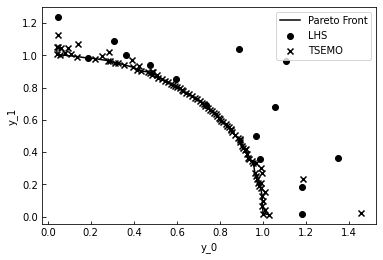

In [15]:
lab.pareto_plot()

In [18]:
hypervolume(lab.pareto_data[['y_0', 'y_1']].to_numpy(), [11,11])

119.65194323239311

In [24]:
experiments

,x_0,x_1,x_2,y_0,y_1,strategy,y_0_variance,y_0_noise,y_0_x_0_lengthscale,y_0_x_1_lengthscale,y_0_x_2_lengthscale,iterations,y_1_variance,y_1_noise,y_1_x_0_lengthscale,y_1_x_1_lengthscale,y_1_x_2_lengthscale
81,0.529031,0.47203,0.445756,0.676216,0.742176,TSEMO,0.858638,0.002479,3.212489,73.537735,3.206437,100,0.7008,0.002479,2.504781,33.315465,4.978001


In [23]:
pareto_data = lab.pareto_data
pareto_data[(pareto_data['x_0']>0.49)&(pareto_data['x_0']<0.51)]

,computation_t,experiment_t,iterations,strategy,x_0,x_1,x_2,y_0,y_0_noise,y_0_variance,y_0_x_0_lengthscale,y_0_x_1_lengthscale,y_0_x_2_lengthscale,y_1,y_1_noise,y_1_variance,y_1_x_0_lengthscale,y_1_x_1_lengthscale,y_1_x_2_lengthscale
50,72.885,0.0238981,NaN,TSEMO,0.504847,0.419792,0.461530,0.707256,NaN,NaN,NaN,NaN,NaN,0.718108,NaN,NaN,NaN,NaN,NaN
97,80.9609,0.0274248,NaN,TSEMO,0.496483,0.458281,0.440273,0.714776,NaN,NaN,NaN,NaN,NaN,0.706922,NaN,NaN,NaN,NaN,NaN


In [22]:
lab.data[lab.data['strategy']=='TSEMO']

,computation_t,experiment_t,iterations,strategy,x_0,x_1,x_2,y_0,y_0_noise,y_0_variance,y_0_x_0_lengthscale,y_0_x_1_lengthscale,y_0_x_2_lengthscale,y_1,y_1_noise,y_1_variance,y_1_x_0_lengthscale,y_1_x_1_lengthscale,y_1_x_2_lengthscale
15,73.97,0.025182,NaN,TSEMO,0.124833,0.950282,0.570621,1.184597,NaN,NaN,NaN,NaN,NaN,0.235308,NaN,NaN,NaN,NaN,NaN
16,69.052,0.0227399,NaN,TSEMO,0.008931,0.975987,0.019932,1.456886,NaN,NaN,NaN,NaN,NaN,0.020441,NaN,NaN,NaN,NaN,NaN
17,69.4382,0.0223081,NaN,TSEMO,0.941704,0.659721,0.342914,0.096032,NaN,NaN,NaN,NaN,NaN,1.045787,NaN,NaN,NaN,NaN,NaN
18,83.5232,0.0492129,NaN,TSEMO,0.169301,0.671625,0.530611,0.994170,NaN,NaN,NaN,NaN,NaN,0.270802,NaN,NaN,NaN,NaN,NaN
19,86.8174,0.0243907,NaN,TSEMO,0.333477,0.485789,0.426138,0.870812,NaN,NaN,NaN,NaN,NaN,0.503025,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,86.3887,0.0239279,NaN,TSEMO,0.271195,0.413233,0.453369,0.919465,NaN,NaN,NaN,NaN,NaN,0.417234,NaN,NaN,NaN,NaN,NaN
110,89.007,0.0242312,NaN,TSEMO,0.688204,0.600876,0.488145,0.475274,NaN,NaN,NaN,NaN,NaN,0.891546,NaN,NaN,NaN,NaN,NaN
111,82.6666,0.0228529,NaN,TSEMO,0.213864,0.405458,0.440612,0.955870,NaN,NaN,NaN,NaN,NaN,0.333763,NaN,NaN,NaN,NaN,NaN
112,84.5713,0.0253732,NaN,TSEMO,0.362041,0.431355,0.438550,0.849757,NaN,NaN,NaN,NaN,NaN,0.543103,NaN,NaN,NaN,NaN,NaN
